In [70]:
import numpy as np 
import pandas as pd 
import altair as alt
import matplotlib.pyplot as plt
import re
import json

import os
print(os.listdir("./data"))

testFilePath = "./data/rule1-4_trial3.twts"

['12ktweets.twts', 'rule1-4_trial3.twts', 'ProposedRules.txt', 'testtweets.twts', 'testdatasets', 'self.twts', '40ktweets.twts', 'selectedtweets', 'rules3-4_trial2.twts', 'rules1-4_trial1.twts', 'skeptic.twts']


For this notebook, some hypotheses checks will be done on our newly filtered data. First, I will adjust our stream parameters. It will be changed to:

```
https://api.twitter.com/2/tweets/search/stream?tweet.fields=created_at,public_metrics&expansions=author_id,referenced_tweets.id
```
where *referenced_tweets.id* has been added to our parameter listing.

Next, for our two most popular rules (SocietalShift, and SelfAndID), additional negative constraints will be added: *" -is:retweet -is:quote -is:reply"*

Which will cut down our search to only original posts. The two less popular rules will not recieve these constraints, as there match rate is very low.

Analysis will be done on the tweets and metrics recorded on the two sets.


In [71]:
#Main import and cleaning code goes here.

#String, Int -> DataFrame!
def generatedataframe(path,writeLimit):
    if ((type(writeLimit) != int)):
        raise("Error: writeLimit not an integer. Check argument.")
        
    cols = ["tweetid", "text", "created_at",
            "tagid","tag","userid","username",
            "retweetcount","replycount","likecount",
            "quotecount"]
    tempDF = pd.DataFrame(columns=cols)
    tweetDF = pd.DataFrame(columns=cols)
    lineCount = 0
    ##Note! On a rare occasion, two or more tags can match. THis currently chooses the first tag set
    ##Information loss can occur.
    with open(path) as fp:
        line = fp.readline()
        while line:
            if (lineCount == writeLimit):
                tweetDF = pd.concat([tweetDF,tempDF],copy=False).reset_index().drop(columns="index")
                tempDF = pd.DataFrame(columns=cols) #blow it all to hell!!
                lineCount = 0
            jsonObj = json.loads(line)
            #done for readibility, not code terseness
            c1 = jsonObj["data"]["id"]
            c2 = jsonObj["data"]["text"]
            c3 = jsonObj["data"]["created_at"]
            c4 = jsonObj['matching_rules'][0]["id"]
            c5 = jsonObj['matching_rules'][0]["tag"]
            c6 = jsonObj["data"]["author_id"]
            #Note: This assumes the first includes user is the poster (!)
            c7 = jsonObj["includes"]["users"][0]["username"]
            c8 = jsonObj["data"]["public_metrics"]["retweet_count"]
            c9 = jsonObj["data"]["public_metrics"]["reply_count"]
            c10 = jsonObj["data"]["public_metrics"]["like_count"]
            c11 = jsonObj["data"]["public_metrics"]["quote_count"]
            tempDF.loc[len(tempDF.index)] = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11]    
            line = fp.readline()
            lineCount = lineCount + 1
                
        if (lineCount > 0): #cadd the last of the rows to final tweetDF.
            tweetDF = pd.concat([tweetDF,tempDF],copy=False).reset_index().drop(columns="index")
        fp.close()
        
    #Quickly convert to numbers.
    #Unlikely we will hit over 2^16 for tweet metrics. Also, are targets are little people anyways,
    #not huge twitter accounts. Downcasting will save some space.
    tweetDF = tweetDF.astype({"tweetid": "int64"}, copy=False) 
    tweetDF = tweetDF.astype({"tagid": "int64"}, copy=False) 
    tweetDF = tweetDF.astype({"userid": "int64"}, copy=False) 
    tweetDF = tweetDF.astype({"retweetcount": "int16"}, copy=False) 
    tweetDF = tweetDF.astype({"replycount": "int16"}, copy=False) 
    tweetDF = tweetDF.astype({"likecount": "int16"}, copy=False) 
    tweetDF = tweetDF.astype({"quotecount": "int16"}, copy=False) 
    #[!] for now, I don't use the date string, eventhough it is recorded. To be formatted into a DateTime object later

    tweetDF.info()
    return tweetDF

tweetDF = generatedataframe(testFilePath,5000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100195 entries, 0 to 100194
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweetid       100195 non-null  int64 
 1   text          100195 non-null  object
 2   created_at    100195 non-null  object
 3   tagid         100195 non-null  int64 
 4   tag           100195 non-null  object
 5   userid        100195 non-null  int64 
 6   username      100195 non-null  object
 7   retweetcount  100195 non-null  int16 
 8   replycount    100195 non-null  int16 
 9   likecount     100195 non-null  int16 
 10  quotecount    100195 non-null  int16 
dtypes: int16(4), int64(3), object(4)
memory usage: 6.1+ MB


#### Time and Space Estimates:

1k tweets = 75kb, takes a few seconds
5k tweets = 351kb, takes 10 seconds
20k tweets = 1.4mb, takes 1 min 5 sec
40k tweets = 2.7mb, 3min 48 seconds

So it is estimated that it will take about 10+ minutes to load 100k tweets, everytime. I suspect appending to a dataframe slows down after a critical point, not because reading 10k+ lines from a file is inefficient. To test this, I modified the read/basic format loop to write every 5000 entries.

After our amendments to code:
40k tweets: 1 min and 3 sec!
100k tweets in 2min 40sec

Speedup by a factor of 4! with our intermittant DF writing.



In [69]:
tweetDF.tail(5)

,tweetid,text,created_at,tagid,tag,userid,username,retweetcount,replycount,likecount,quotecount
39995,1563604559494541316,@thatroblennon Damn. You're so right,2022-08-27T19:09:12.000Z,1563582770315665410,SelfandID,228834325,BenjaminPutano,0,0,0,0
39996,1563604564443480064,RT @kylegriffin1: Several people arrested as p...,2022-08-27T19:09:13.000Z,1563582770315665410,SelfandID,845722998,Davet_33,942,0,0,0
39997,1563604565131292678,RT @SanctionsKills: The West and MSM needs to ...,2022-08-27T19:09:13.000Z,1563582770315665411,HealthySkepticism,1469974512687005703,EndrisMehamed3,3,0,0,0
39998,1563604565903085568,RT @safemoon: @freelunch30 An image. No produc...,2022-08-27T19:09:13.000Z,1563582770315665410,SelfandID,1406003717594288139,ReyhaanKhan1,54,0,0,0
39999,1563604563898249218,RT @NerdySasquatch: So Ezra Miller gets away w...,2022-08-27T19:09:13.000Z,1563582770315665410,SelfandID,1260500187832860672,DragoonTwilight,330,0,0,0


Next, I calcualte some basic statistics for our 100k datasetL

In [74]:
def basicInfo() :
    print(tweetDF.shape)
    print()
    print(tweetDF.isnull().sum())
    print()
    print(tweetDF.info())
    return

basicInfo()

(100195, 11)

tweetid         0
text            0
created_at      0
tagid           0
tag             0
userid          0
username        0
retweetcount    0
replycount      0
likecount       0
quotecount      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100195 entries, 0 to 100194
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweetid       100195 non-null  int64 
 1   text          100195 non-null  object
 2   created_at    100195 non-null  object
 3   tagid         100195 non-null  int64 
 4   tag           100195 non-null  object
 5   userid        100195 non-null  int64 
 6   username      100195 non-null  object
 7   retweetcount  100195 non-null  int16 
 8   replycount    100195 non-null  int16 
 9   likecount     100195 non-null  int16 
 10  quotecount    100195 non-null  int16 
dtypes: int16(4), int64(3), object(4)
memory usage: 6.1+ MB
None


In [75]:
#Get a tag percentage summary

distDF = pd.DataFrame(columns=["sum","percentage"],index=tweetDF.tag.unique())
distDF["sum"] = tweetDF.groupby('tag')['tagid'].count()
totalSum = tweetDF.shape[0]
for strIndex in distDF.index:
    distDF["percentage"][strIndex] = (distDF["sum"][strIndex]*100)/totalSum

distDF
#5% societal shift, 61% self, 2.5% searchthevoid, 32% Skepticism.

/tmp/ipykernel_24167/56264166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distDF["percentage"][strIndex] = (distDF["sum"][strIndex]*100)/totalSum


,sum,percentage
SocietalShift,8003,7.987425
SelfandID,67216,67.085184
HealthySkepticism,24906,24.857528
SearchTheVoid,70,0.069864


So no nulls, fairly clean data, and a very interesting Tag distribution. Compare this to our previous distribution:

5% societal shift, 61% self, 2.5% searchthevoid, 32% Skepticism.

Societal Shift is political, and may fluctuate wildly. Apparently quite a few people were not searching the void, on the day I was mining tweets.

What about out Tweet Metrics? I see a lot of zeros...

Lets calculate: 
- A box plot for all our values.
- Number of non-zero values.
- max range for all columns (min and max)

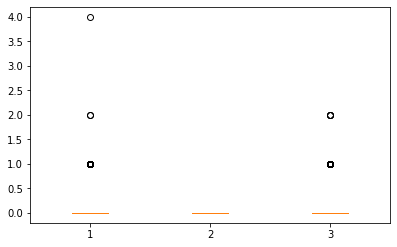

In [87]:
import matplotlib.pyplot as plt
import numpy as np
  
data_1 = tweetDF["replycount"]
data_2 = tweetDF["retweetcount"]
data_3 = tweetDF["quotecount"]
data_4 = tweetDF["likecount"]
data = [data_1, data_3, data_4]
 
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
 
# show plot
plt.show()

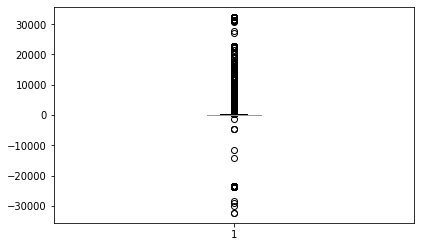

In [91]:
  
data_2 = tweetDF["retweetcount"]
 
fig2 = plt.figure(figsize =(5, 3))
# Creating axes instance
ax2 = fig2.add_axes([0, 0, 1, 1])
# Creating plot
bp2 = ax2.boxplot(data_2)
 
# show plot
plt.show()


Our likes, quotes and replies are miniscule. Our retweets have a massive range. This is strange. Let us calculate the number of zeros for these columns. From the code below, over 99% of the values are all zeros! After visually inspecting the top five tweets, the count numbers are mostly off (most of them are not zero). 

Further investigation into the tweet metric query must be made. After searching the following Twitter Dev substack, I found the following two posts:

https://twittercommunity.com/t/public-metrics-giving-0-values-for-retweets/166436

https://twittercommunity.com/t/v2-api-returning-0-for-most-of-public-metrics/166669

In which two users have similar problems. They see RT counts that are large values, but the other counts are zeroed out. This is because public_metrics will return zero for Retweets, and only display the retweet value of the original comment. 

To get the full counts, one must reference the "original" tweet, for any tweet that is RTed, or a reply. 
For a retweet, the RT value will show, but no other votes count for it (they are added to the original tweet).

Interestingly, If we find just a simple reply, we also get "zeros" for likes, eventhough the user has generated their own (derived) content. Once again, we can see all metrics for the original tweet (what was replied to), but not the likes of the reply itself. When the reply is inspected on twitter.com, the likes can be seen, however. This has serious implications - only original tweets have full public metrics (!).

Improvements to our gathering:

1) Check tweets if they are retweets or replies (screen out at the filter level)?

2) Add original tweet extension to twitter stream URL to recover original tweet, perform additional checks.



In [95]:
#Like Count
likecount = (tweetDF['likecount'] == 0).sum()
likecount
#Reply
replycount = (tweetDF['replycount'] == 0).sum()
replycount
#Quote
quotecount = (tweetDF['quotecount'] == 0).sum()
quotecount


99990

99437

100195

#### Checking our ratio of tweets (retweets, replies):

We can do this by searching the tweet *text* column for "RT" and "@" symbols. We can generally assume that encountering RT or @ in alternate contexts (as part of all capitalized words, or ASCII art), are rare (less than 1% occurance), so our estimates should be decent.

Note that a RT necessitates AT-ing the author of the original tweet. So 
our search for @ symbols must contain all RT search results. 

RTs *imply* @ symbol was used.
But using an @ symbol *does not imply* we RTed.

We see below that there are tonnes of RTs and @ tweets, calling out other users.

In [112]:
#remember that we can plug in a series of truth values, to pick out rows.
rtCount = tweetDF[tweetDF["text"].str.contains("RT")].shape[0]
atCount = tweetDF[tweetDF["text"].str.contains("@")].shape[0]

print("Percentage of RTs::" + str(100*rtCount/tweetDF.shape[0]))
print("Percentage of ATs::" + str(100*atCount/tweetDF.shape[0]))


Percentage of RTs::51.04246718898148
Percentage of ATs::84.43834522680773


#### Adjusting our filters and parameters, next steps....

Since we cannot get full metrics on replies, and retweets, we need to adjust our filter rules and GET parameters. A new notebook to verify hypotheses about public_metrics will be made. 

In [104]:
#Remember this: 
tweetDF.iloc[510:530]

,tweetid,text,created_at,tagid,tag,userid,username,retweetcount,replycount,likecount,quotecount
510,1563587700413718528,RT @HanbenP: Journey https://t.co/ZFkD8TSclS,2022-08-27T18:02:12.000Z,1563582770315665410,SelfandID,1398094171303514117,mugentrader,7,0,0,0
511,1563587699981705219,"you're vulnerable, you're vulnerable, you are ...",2022-08-27T18:02:12.000Z,1563582770315665410,SelfandID,1516497821826002957,thefamjewelsbot,0,0,0,0
512,1563587699994284033,RT @woonomic: Remember when someone (often a p...,2022-08-27T18:02:12.000Z,1563582770315665410,SelfandID,715329524,LeongPhuiYee,167,0,0,0
513,1563587699763998720,RT @stevesnr50: To all the people who believe ...,2022-08-27T18:02:12.000Z,1563582770315665411,HealthySkepticism,1562745806599307264,Harry_TH1D,19,0,0,0
514,1563587701101961223,RT @AloneBoy_0010: My love for you is a journe...,2022-08-27T18:02:12.000Z,1563582770315665410,SelfandID,1451375303448829954,fangirlphoton,84,0,0,0
515,1563587698731888643,RT @SaniaNishtar: Deeply humbled to have been ...,2022-08-27T18:02:12.000Z,1563582770315665409,SocietalShift,3326744673,pti_zaragosa,1137,0,0,0
516,1563587699751002112,@mildanalyst Having the nerve to call misinfor...,2022-08-27T18:02:12.000Z,1563582770315665411,HealthySkepticism,303898586,anroremo,0,0,0,0
517,1563587701944696833,@JshBet8 Haha! That last comment though. What ...,2022-08-27T18:02:12.000Z,1563582770315665410,SelfandID,1524830025865908225,joshisnotarobot,0,0,0,0
518,1563587705434685441,@American1976200 @JackPosobiyatch @Chui2021 @m...,2022-08-27T18:02:13.000Z,1563582770315665411,HealthySkepticism,1099739155196796930,L_instigateur,0,0,0,0
519,1563587703798579200,"Soren likes badminton, books and bicycles. He ...",2022-08-27T18:02:13.000Z,1563582770315665410,SelfandID,854272141742579712,QudachIndia,0,0,0,0
